In [ ]:
import numpy as np
import pandas as pd

from plotnine import ggplot, aes, stat_qq, stat_qq_line, geom_boxplot, geom_density, coord_flip, geom_vline, geom_hline, geom_histogram, labs, facet_grid, facet_wrap
import seaborn as sns

import scipy
import scipy.stats 
from scipy.stats import anderson, shapiro, chi2_contingency

import statsmodels.api as sm
import statsmodels.stats.multicomp as mc
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


In [7]:
sales = pd.read_csv('https://raw.githubusercontent.com/IAA-Faculty/statistical_foundations/master/sales_train.csv')
website = pd.read_csv('https://raw.githubusercontent.com/IAA-Faculty/statistical_foundations/master/website_clicks.csv')
buy = pd.read_csv('https://raw.githubusercontent.com/IAA-Faculty/statistical_foundations/master/product_buy.csv')

# Question Set 1

The data set sales is a training data set that contains information for daily sales from a large franchise.  The data set contains randomly selected days from 400 locations to measure the impact of holidays, weekends, population size, layout of store, number of years of operation of store and state on sales.  The goal is to find the best linear predictor (do NOT use higher order terms...NO power terms or interactions).  Since this is a training data set, you do not need to split this data.  The data is organized as follows:

holiday: 1 = holiday and 0= not a holiday

weekend: 1 = weekend and 0 = weekday

pop: population size in 10,000s

display: layout of the store with 1 = custom design and 0 = recommended design

open: number of years the location was in operation

state: the state in which the store is located with 1 = Georgia, 2 = North Carolina, 3 = South Carolina and 4 = Georgia

y: Daily sales amount

Be aware of data formats! For any statistical tests, use a significance level of 0.05.

In [8]:
sales.head()

,holiday,weekend,pop,display,open,state,y
0,0,0,99,0,14,1,501.433185
1,0,0,91,1,15,1,490.498907
2,0,0,84,0,19,1,482.654291
3,0,1,73,0,13,1,476.013940
4,0,0,98,1,17,1,493.071136


In [9]:
sales['holiday'] = sales['holiday'].astype('category')
sales['weekend'] = sales['weekend'].astype('category')
sales['display'] = sales['display'].astype('category')
sales['state'] = sales['state'].astype('category')

sales.head()

,holiday,weekend,pop,display,open,state,y
0,0,0,99,0,14,1,501.433185
1,0,0,91,1,15,1,490.498907
2,0,0,84,0,19,1,482.654291
3,0,1,73,0,13,1,476.013940
4,0,0,98,1,17,1,493.071136


# Question set 2

The website dataset contains information regarding website clicks for a given product.  The company is interested to see if the location (x1) of the product and the theme (x2) of the webpage have any impact on the number of clicks (y) for a given product.  There are a total of 4 different page locations and 3 different webpage themes.

You will use ALL data to perform this analysis (i.e. no need to split into training/validation). Use this information and data set to answer the following questions.

In [47]:
website = pd.read_csv('https://raw.githubusercontent.com/IAA-Faculty/statistical_foundations/master/website_clicks.csv')

In [14]:
website.head()

,Obs,x1,x2,y
0,1,Upper Left,Classic,50
1,2,Upper Right,Classic,52
2,3,Lower Left,Classic,52
3,4,Lower Right,Classic,52
4,5,Upper Left,Classic,54


In [48]:
website['x1'] = website['x1'].astype('category')
website['x2'] = website['x2'].astype('category')

## Question 9

Compute the mean number of clicks by webpage location.  Which location has the lowest average number of clicks in this sample?

In [49]:
website.groupby('x1').agg(
    mean = ('y', 'mean')
)

C:\Users\wdcru\AppData\Local\Temp\ipykernel_33436\298014729.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,mean
x1,
Lower Left,53.366667
Lower Right,49.066667
Upper Left,52.966667
Upper Right,51.866667


Answer: Lower Right

## Question 10

What is the average number of clicks for this location? Use 1 decimal place for your answer.

Answer: 49.1

## Question 11

Is there a significant interaction between the location and theme on the number of webpage clicks with a significance level of 0.05?  Explain why or why not.

In [50]:
website_lm = smf.ols("y ~ x1 * x2", data = website).fit()
sms.anova_lm(website_lm, typ=2)


,sum_sq,df,F,PR(>F)
x1,338.700000,3.0,14.409359,5.807627e-08
x2,123.716667,2.0,7.894942,6.307893e-04
x1:x2,207.350000,6.0,4.410659,5.011268e-04
Residual,846.200000,108.0,NaN,NaN


Answer: Yes at p = 0.0005 < 0.05

## Question 12

Using the previous model, Normality seems like a reasonable assumption.

In [40]:
website['resid'] = website_lm.resid

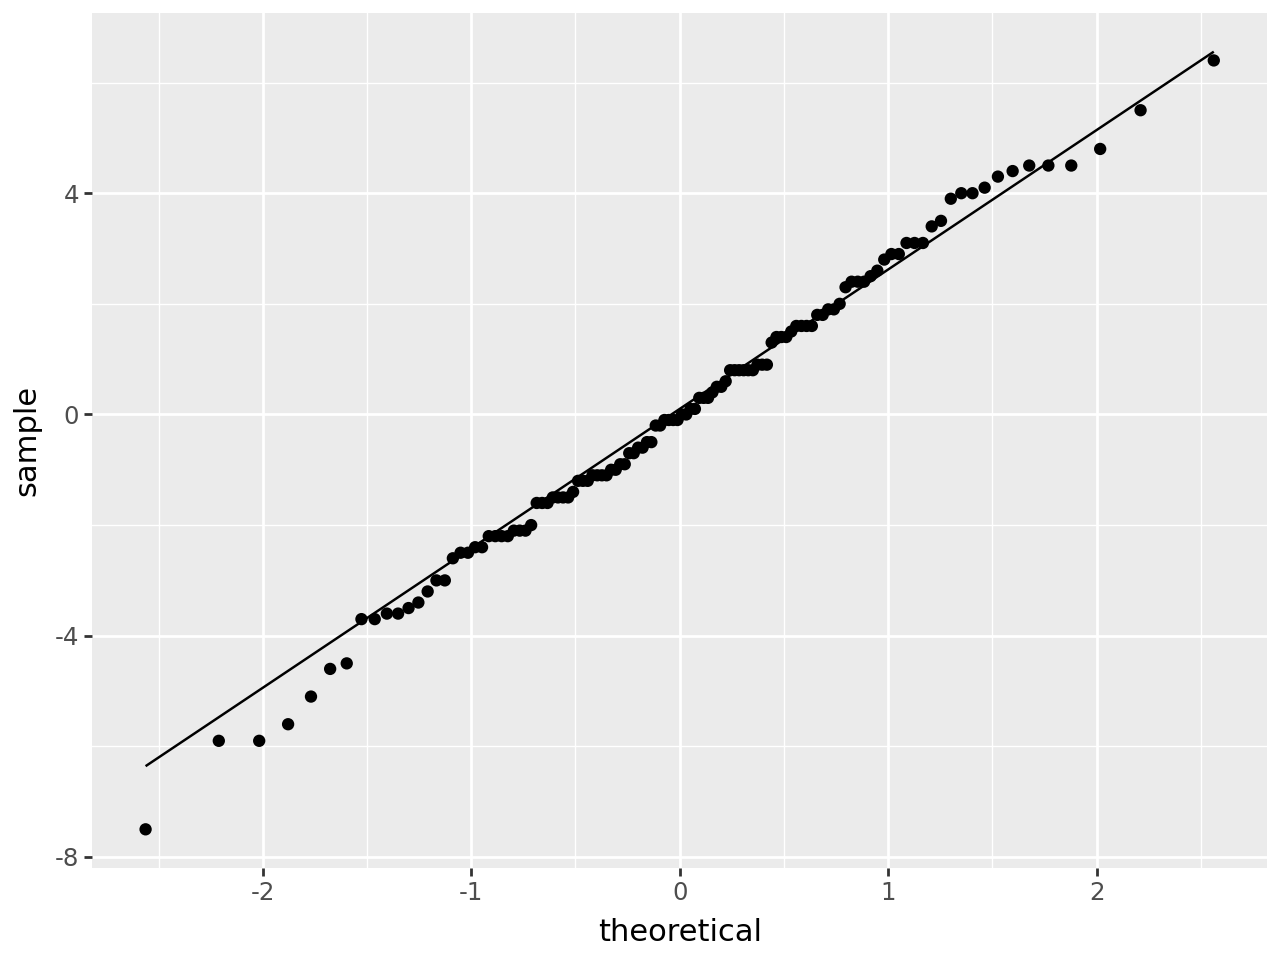

In [43]:
resid_qq = (ggplot(website, aes(sample = website['resid'])) +
            stat_qq() +
            stat_qq_line())

resid_qq.show()

In [45]:
stat, p = scipy.stats.shapiro(website['resid'])
p

np.float64(0.9124312940208258)

## Question 13

Within the Upper Right location, which theme has the highest average number of clicks?

In [46]:
website[website['x1'] == 'Upper Right'].groupby('x2').agg(
    mean = ('y', 'mean')
)

C:\Users\wdcru\AppData\Local\Temp\ipykernel_33436\3705892731.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,mean
x2,
Classic,55.0
Mix,51.9
Modern,48.7


Answer: Classic

## Question 14

What is the average number of clicks for this location/theme combination from the previous question? Use 1 decimal place for your answer.

Answer: 55.0

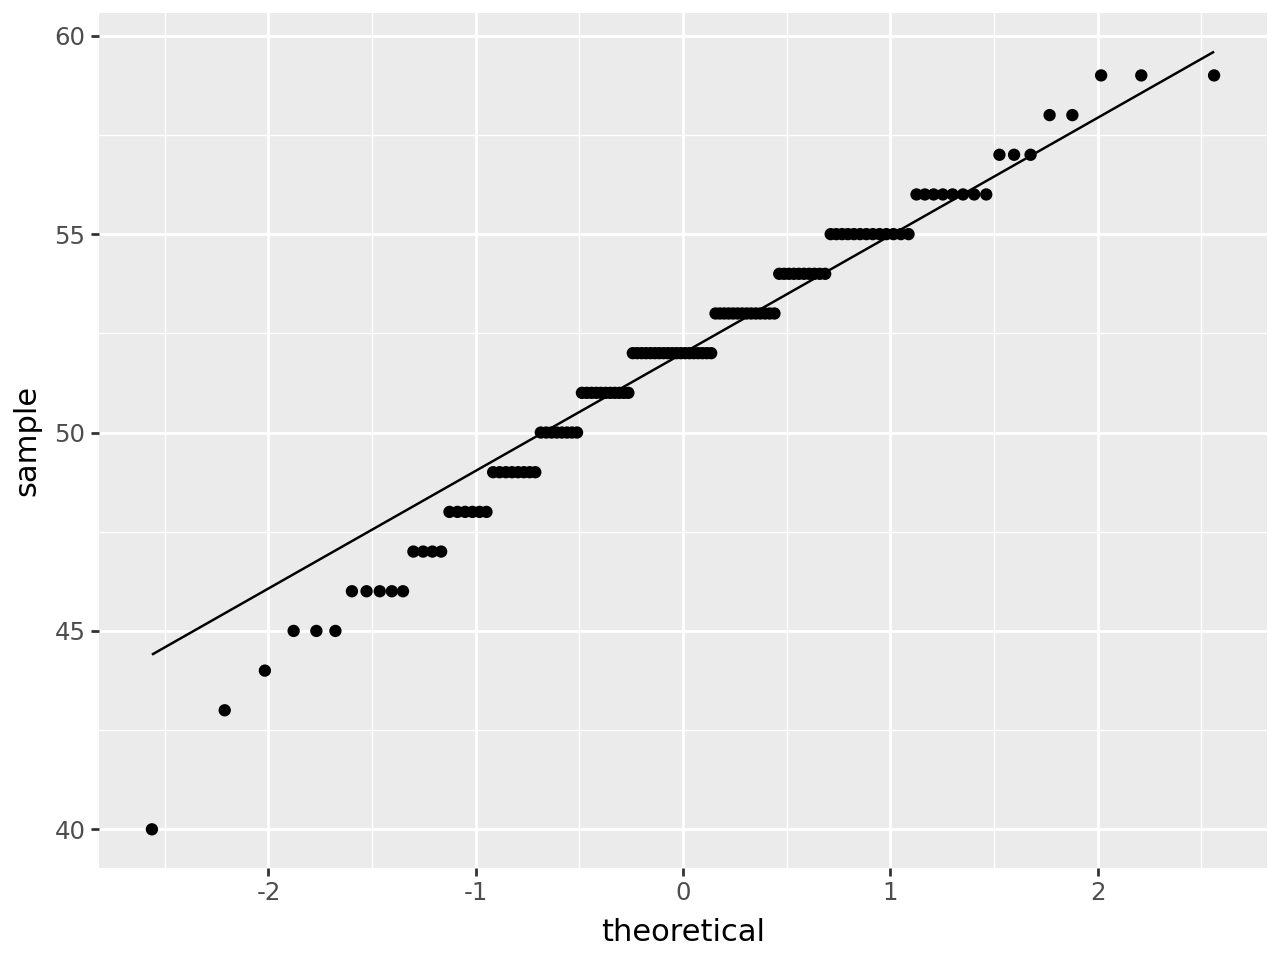

In [51]:
website_qq = (ggplot(website, aes(sample = 'y')) +
  stat_qq() +
  stat_qq_line())

website_qq.show()

In [35]:
stat, p = scipy.stats.shapiro(website['y'])
p

np.float64(0.030364272998449002)

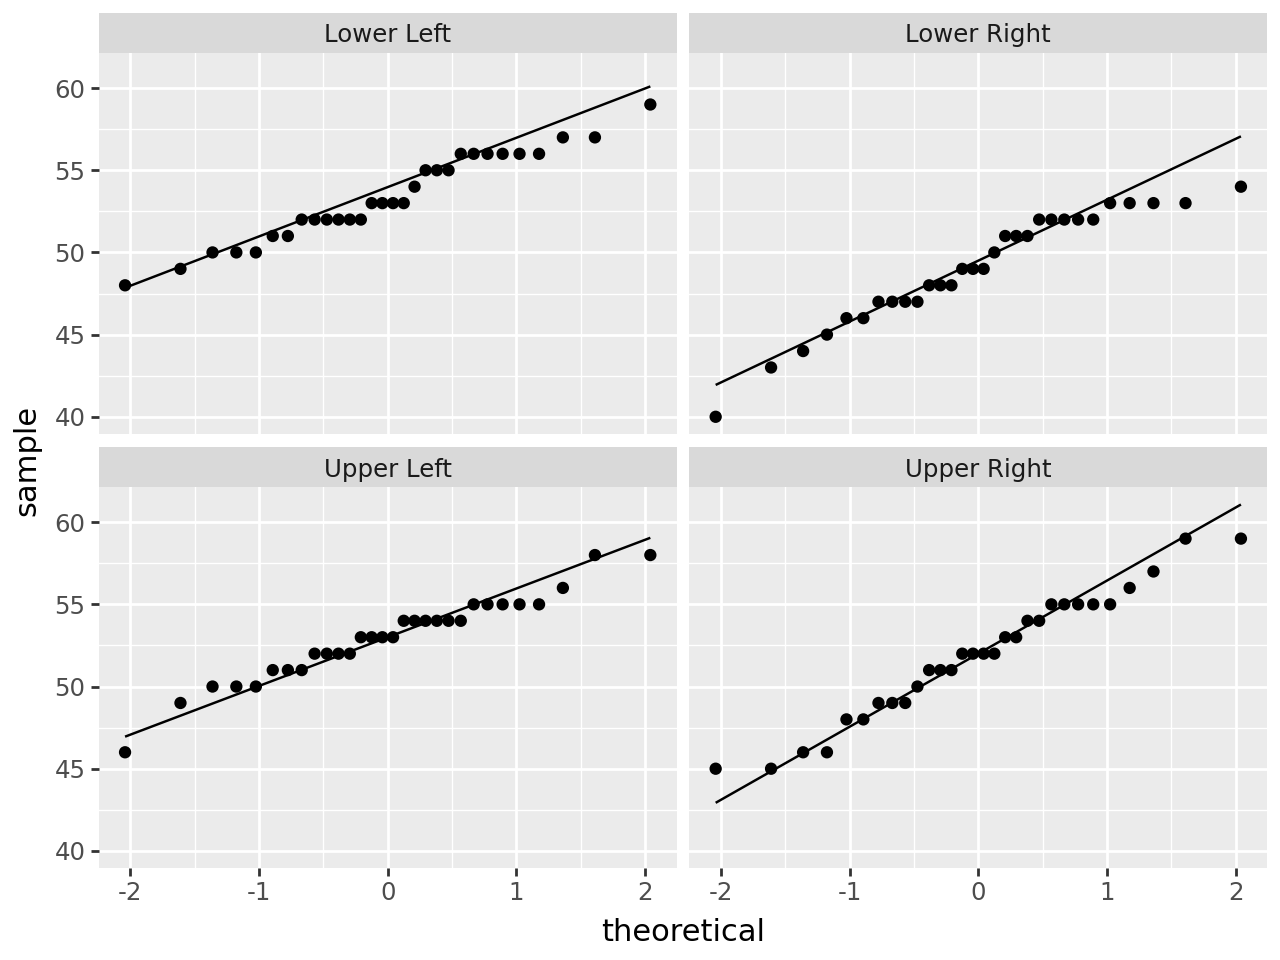

In [31]:
website_qq = (ggplot(website, aes(sample = 'y')) +
  stat_qq() +
  stat_qq_line() +
  facet_wrap('x1'))

website_qq.show()

In [36]:
statLL, pLL = scipy.stats.shapiro(website[website["x1"] == 'Lower Left']['y'])
statLR, pLR = scipy.stats.shapiro(website[website["x1"] == 'Lower Right']['y'])
statUL, pUL = scipy.stats.shapiro(website[website["x1"] == 'Upper Left']['y'])
statUR, pUR = scipy.stats.shapiro(website[website["x1"] == 'Upper Right']['y'])

print(f"LL: {pLL}, LR: {pLR}, UL: {pUL}, UR: {pUR}")

LL: 0.3885946156391019, LR: 0.09218811125545492, UL: 0.4120959301167088, UR: 0.5020606266316896


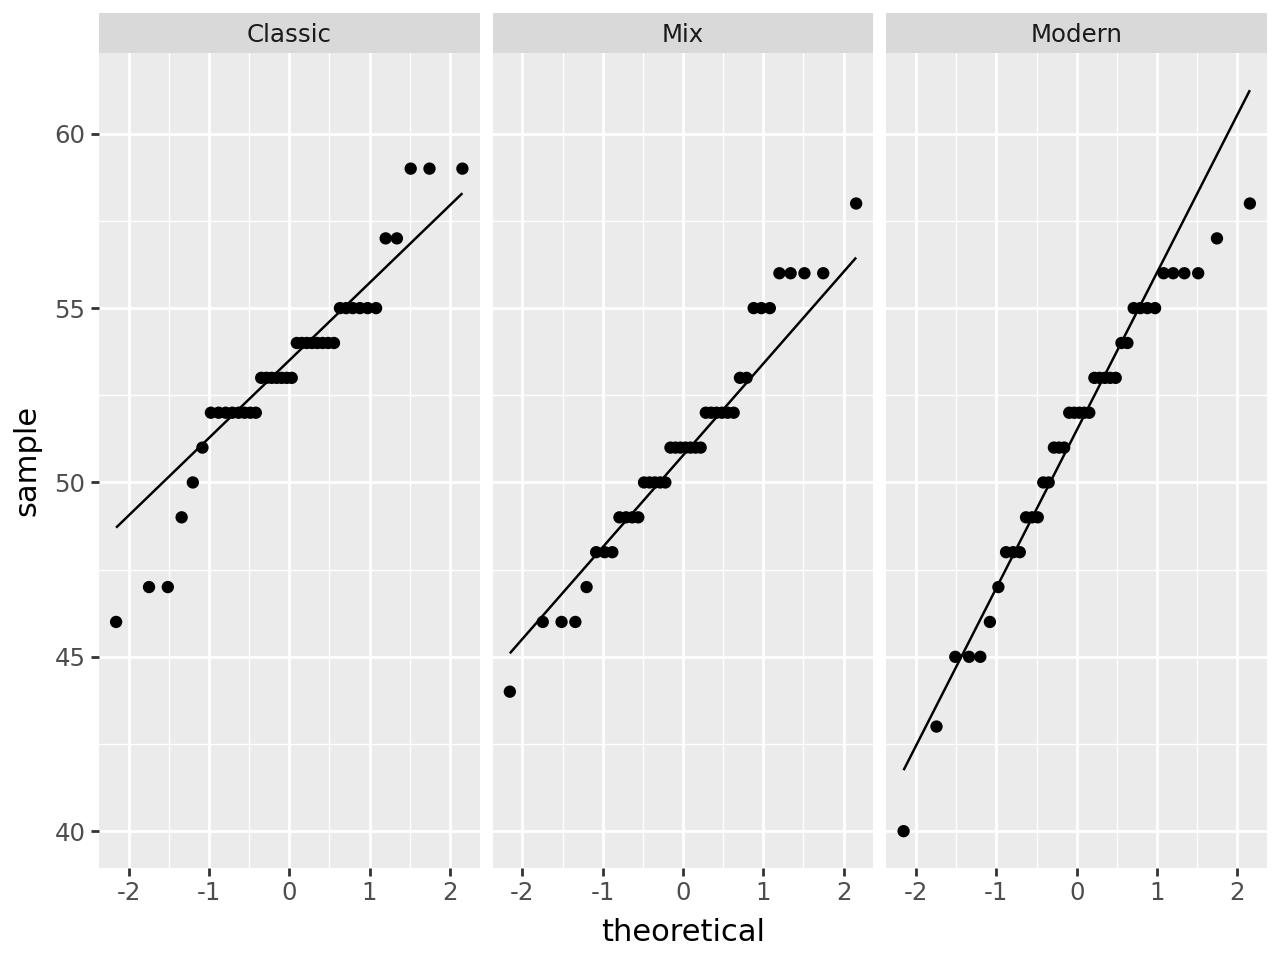

In [32]:
website_qq = (ggplot(website, aes(sample = 'y')) +
  stat_qq() +
  stat_qq_line() +
  facet_wrap('x2'))

website_qq.show()

In [37]:
statClassic, pClassic = scipy.stats.shapiro(website[website["x2"] == 'Classic']['y'])
statMix, pMix = scipy.stats.shapiro(website[website["x2"] == 'Mix']['y'])
statModern, pModern = scipy.stats.shapiro(website[website["x2"] == 'Modern']['y'])

print(f"pClassic: {pClassic}, pMix: {pMix}, pModern: {pModern}")

pClassic: 0.017799272465095432, pMix: 0.4161517164669731, pModern: 0.1585625347163937
